In [1]:
from scipy.integrate import odeint
import numpy as np
from numpy import cos, pi
import matplotlib.pyplot as plt
import time
from pertussis import *
from pertussis.model import vaccine_model
from pertussis.params.main_model import collect_state0
from pertussis.charts import draw_model, plot_stoch_vars
import pymc as pm
from time import clock
%matplotlib inline
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

## Parameters and Data

In [16]:
# State 0
state_0 = collect_state0()
print(state_0)
state_0 = pack(state_0)
time.sleep(0.01)  # makes prints clearer

# Initial Parameters
t_start = 1948
t_end = 2024
step = 365
t_end = expand_time(t_end, step=step)
t_range = np.arange(t_start, t_end + 0, 1)

# Data
data = np.genfromtxt('./data/yearly.csv', delimiter=',', skip_header=1)[:, 1]
data /= 10000
years = np.genfromtxt('./data/yearly.csv', delimiter=',', skip_header=1)[:, 0]
print (years)

(0.2, (0, 0, 0, 0, 0, 0), (0, 0, 0, 0), 0.0001, 0, 0.7999)
[ 1951.  1952.  1953.  1954.  1955.  1956.  1957.  1958.  1959.  1960.
  1961.  1962.  1963.  1964.  1965.  1966.  1967.  1968.  1969.  1970.
  1971.  1972.  1973.  1974.  1975.  1976.  1977.  1978.  1979.  1980.
  1981.  1982.  1983.  1984.  1985.  1986.  1987.  1988.  1989.  1990.
  1991.  1992.  1993.  1994.  1995.  1996.  1997.  1998.  1999.  2000.
  2001.  2002.  2003.  2004.  2005.  2006.  2007.  2008.  2009.  2010.
  2011.  2012.  2013.]


## Model

In [17]:
###### Run Model

# Priors
m1 = pm.Uniform('m1', 0, 5, value=1)
# m2 = pm.Uniform('m2', 0, 0.8, value=0.1)
omega = pm.Uniform('omega', 0, 16, value=4)
phi = pm.Uniform('phi', 0, omega + 0.1, value=2)


@pm.deterministic
def sim(m1=m1, omega=omega, phi=phi):
    # print('A ', end="")
    # T = clock()
    RES = odeint(vaccine_model, state_0, t_range,
                 args=(step, m1, omega, phi),
                 full_output=False)

    # print (RES)
    RES = unpack(RES.T, 1, 6, 4, 1, 1, 1)
    res = reduce_year(RES[3])[1951 - t_start:2014 - t_start]
    # print (clock() - T)
    return res


Y = pm.Normal('Y', mu=sim, tau=1, observed=True, value=data)

In [19]:
mcmc = pm.MCMC([omega, m1, phi, sim, Y], db="ram")
mcmc.sample(iter=20, burn=0)

 [-----------------105%------------------] 21 of 20 complete in 29.8 sec

In [20]:
# print (mcmc.summary())
m_m1 = mcmc.trace('m1')[:].mean()
# m_m2 = mcmc.trace('m2')[:].mean()
m_omega = mcmc.trace('omega')[:].mean()
m_phi = mcmc.trace('phi')[:].mean()

RES = odeint(vaccine_model, state_0, t_range,
             args=(step, m_m1, m_omega, m_phi))
# # Results
x = reduce_time(t_range, start=t_start, step=step)
y = unpack(RES.T, 1, 6, 4, 1, 1, 1)
h = y[0] + y[1].sum(axis=0) + y[2].sum(axis=0)
y.append(h)

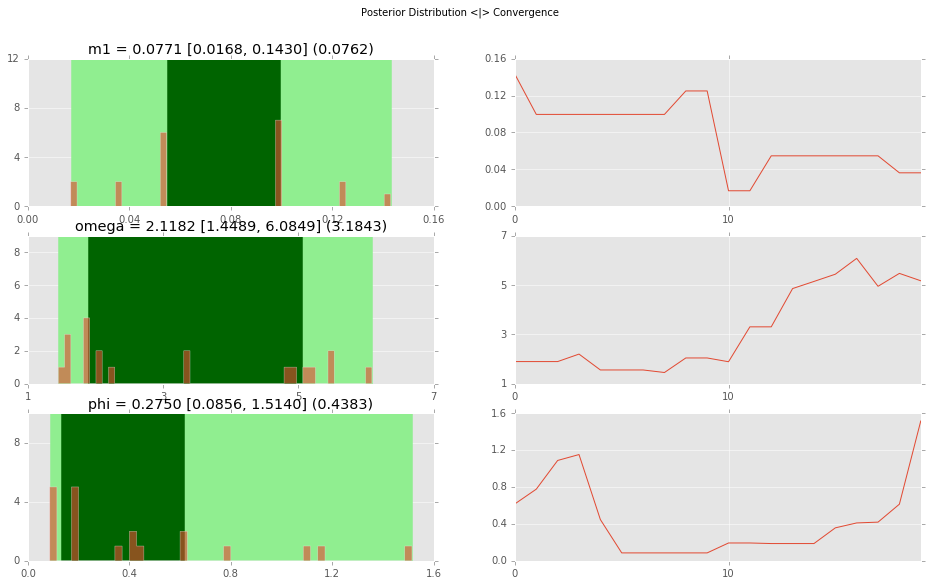

In [21]:
plot_stoch_vars(mcmc)
plt.show()

(0, 0.001)

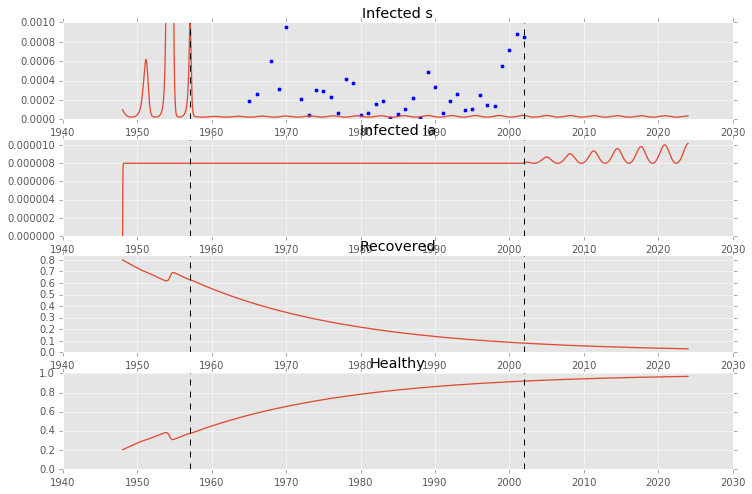

In [24]:
fig1, ax1 = draw_model(x, y[3:7], ["Infected s", "Infected Ia", "Recovered", "Healthy"], split=0)
ax1[0].scatter(years, data)
ax1[0].set_ylim([0,0.001])

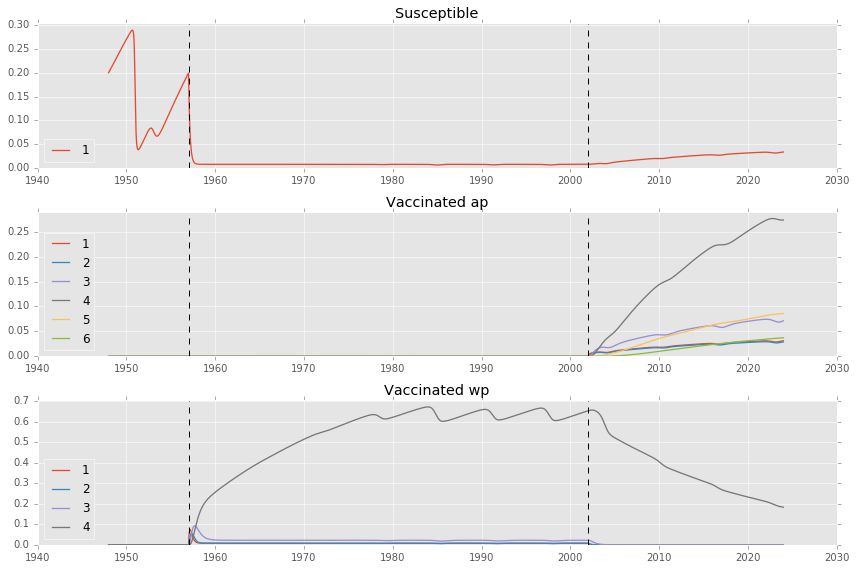

In [10]:
#
fig2, ax2 = draw_model(x, y[0:3], ["Susceptible", "Vaccinated ap", "Vaccinated wp"], split=False)
plt.tight_layout()
plt.show()